In [58]:
import kagglehub
import pandas

path = kagglehub.dataset_download("erdemtaha/cancer-data")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\renat\.cache\kagglehub\datasets\erdemtaha\cancer-data\versions\1


In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [60]:
path = Path(path) / Path("Cancer_Data.csv")
data = pd.read_csv(path)
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# EDA

First, we must understand the dataset. We can start by looking at its structure for features and identifying the target variable.

In [61]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    str    
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             569 non-null

There are 569 entries in this dataset. All columns have fully populated values, so we can expect no missing values. This is corroborated below.

The only exception to this, is the `Unnamed` column, which seems to just be a padding element for this dataset file. It can be dropped by default.

In [62]:
data.drop(columns=["Unnamed: 32"], inplace=True)

In [63]:
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In this case, the project at hand is looking to predict the the type of a cancer, whether it is benign (`B`) or malignant (`M`).

The following is a list of columns and their descriptions, according to the dataset description in [Kaggle](https://www.kaggle.com/datasets/erdemtaha/cancer-data).

| #  | Variable Name           | Type                 | Missing Values    | Description                              |
| -- | ----------------------- | -------------------- | ----------------- | ---------------------------------------- |
| 1  | id                      | Integer              | No                | Unique patient identifier                |
| 2  | diagnosis               | Categorical (Binary) | No                | M = Malignant, B = Benign                |
| 3  | radius_mean             | Float                | No                | Mean tumor radius                        |
| 4  | texture_mean            | Float                | No                | Mean texture (gray-scale variation)      |
| 5  | perimeter_mean          | Float                | No                | Mean tumor perimeter                     |
| 6  | area_mean               | Float                | No                | Mean tumor area                          |
| 7  | smoothness_mean         | Float                | No                | Mean smoothness (local radius variation) |
| 8  | compactness_mean        | Float                | No                | Mean compactness                         |
| 9  | concavity_mean          | Float                | No                | Mean concavity                           |
| 10 | concave points_mean     | Float                | No                | Mean concave points                      |
| 11 | symmetry_mean           | Float                | No                | Mean symmetry                            |
| 12 | fractal_dimension_mean  | Float                | No                | Mean fractal dimension                   |
| 13 | radius_se               | Float                | No                | Standard error of radius                 |
| 14 | texture_se              | Float                | No                | Standard error of texture                |
| 15 | perimeter_se            | Float                | No                | Standard error of perimeter              |
| 16 | area_se                 | Float                | No                | Standard error of area                   |
| 17 | smoothness_se           | Float                | No                | Standard error of smoothness             |
| 18 | compactness_se          | Float                | No                | Standard error of compactness            |
| 19 | concavity_se            | Float                | No                | Standard error of concavity              |
| 20 | concave points_se       | Float                | No                | Standard error of concave points         |
| 21 | symmetry_se             | Float                | No                | Standard error of symmetry               |
| 22 | fractal_dimension_se    | Float                | No                | Standard error of fractal dimension      |
| 23 | radius_worst            | Float                | No                | Worst (largest) radius                   |
| 24 | texture_worst           | Float                | No                | Worst texture                            |
| 25 | perimeter_worst         | Float                | No                | Worst perimeter                          |
| 26 | area_worst              | Float                | No                | Worst area                               |
| 27 | smoothness_worst        | Float                | No                | Worst smoothness                         |
| 28 | compactness_worst       | Float                | No                | Worst compactness                        |
| 29 | concavity_worst         | Float                | No                | Worst concavity                          |
| 30 | concave points_worst    | Float                | No                | Worst concave points                     |
| 31 | symmetry_worst          | Float                | No                | Worst symmetry                           |
| 32 | fractal_dimension_worst | Float                | No                | Worst fractal dimension                  |

## Feature variable analysis

Once we have the list of columns, we can identify the feature variables that will aid in predicting the target.

In [64]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


### Numerical Features

The numerical features are the following:
- `radius_mean`
- `texture_mean`
- `perimeter_mean`
- `area_mean`
- `smoothness_mean`
- `compactness_mean`
- `concavity_mean`
- `concave points_mean`
- `symmetry_mean`
- `fractal_dimension_mean`
- `radius_se`
- `texture_se`
- `perimeter_se`
- `area_se`
- `smoothness_se`
- `compactness_se`
- `concavity_se`
- `concave points_se`
- `symmetry_se`
- `fractal_dimension_se`
- `radius_worst`
- `texture_worst`
- `perimeter_worst`
- `area_worst`
- `smoothness_worst`
- `compactness_worst`
- `concavity_worst`
- `concave points_worst`
- `symmetry_worst`
- `fractal_dimension_worst`

They are all continuous variables.

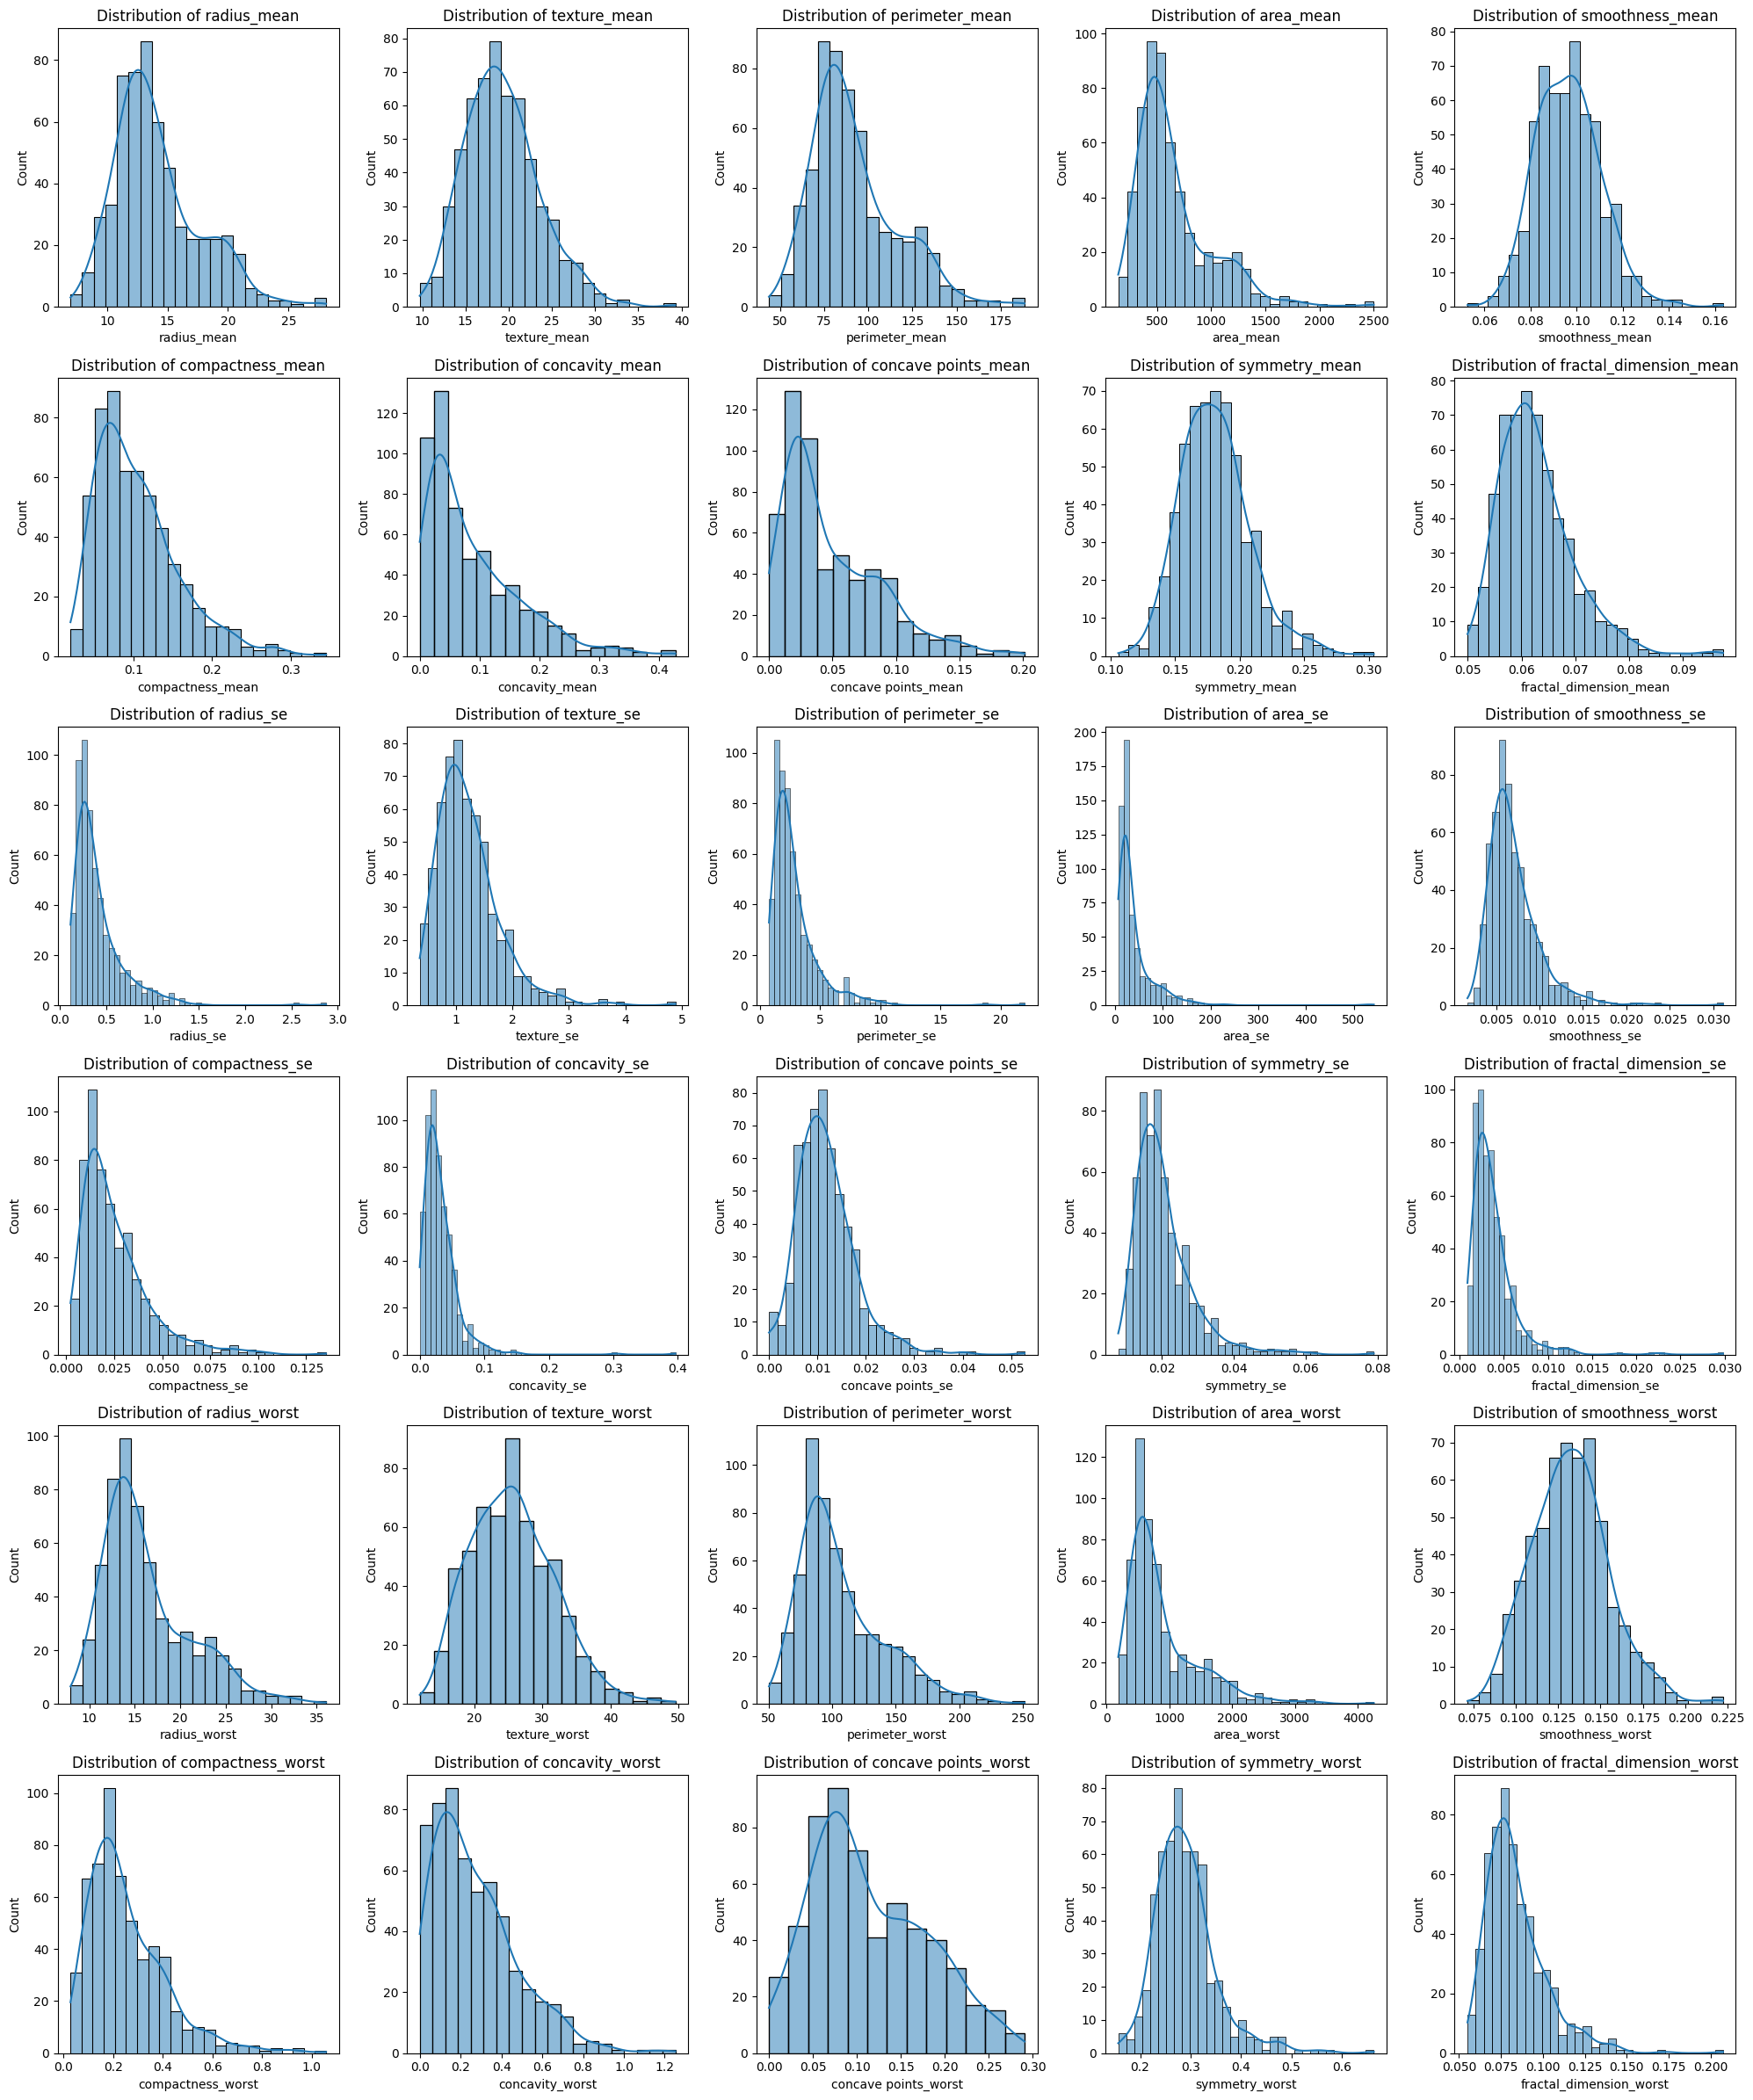

In [65]:
numerical_cols = [
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean',
    'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se',
    'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se',
    'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
    'smoothness_worst', 'compactness_worst', 'concavity_worst',
    'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

fig, axes = plt.subplots(6, 5, figsize=(20, 24))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(data[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

## Target variable analysis

The target variable, as was stated previously, is `diagnosis`. It is a categorical value of `M` or `B` indicating whether a cancer is malignant or benign.

To kick it off, we can take a look at the distribution of diagnoses to get a rough idea of its behavior.

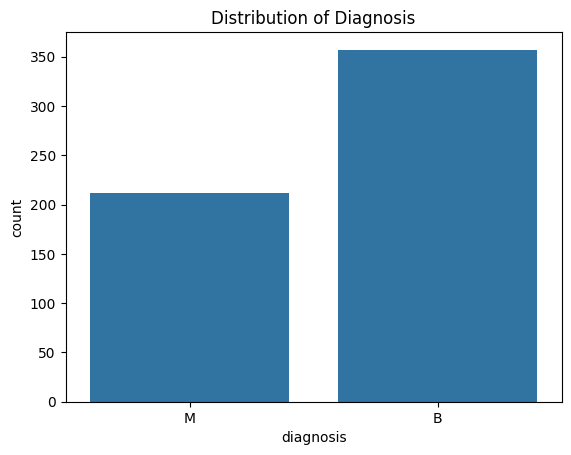

In [66]:
ax = sns.countplot(x="diagnosis", data=data)
ax.set_title("Distribution of Diagnosis")
plt.show()

The above graph shows that the `diagnosis` distribution is imbalanced. This means multiple things:
- Most breast tumors recorded in the dataset are _benign_.
- We will not be able to rely on `accuracy` as an evaluation metric later on. This will be revisited in a further section, but it is worth keeping in mind.

To understand the behavior of the data further, let's graph a correlation matrix that displays all of our (numerical) features against each other and the target.

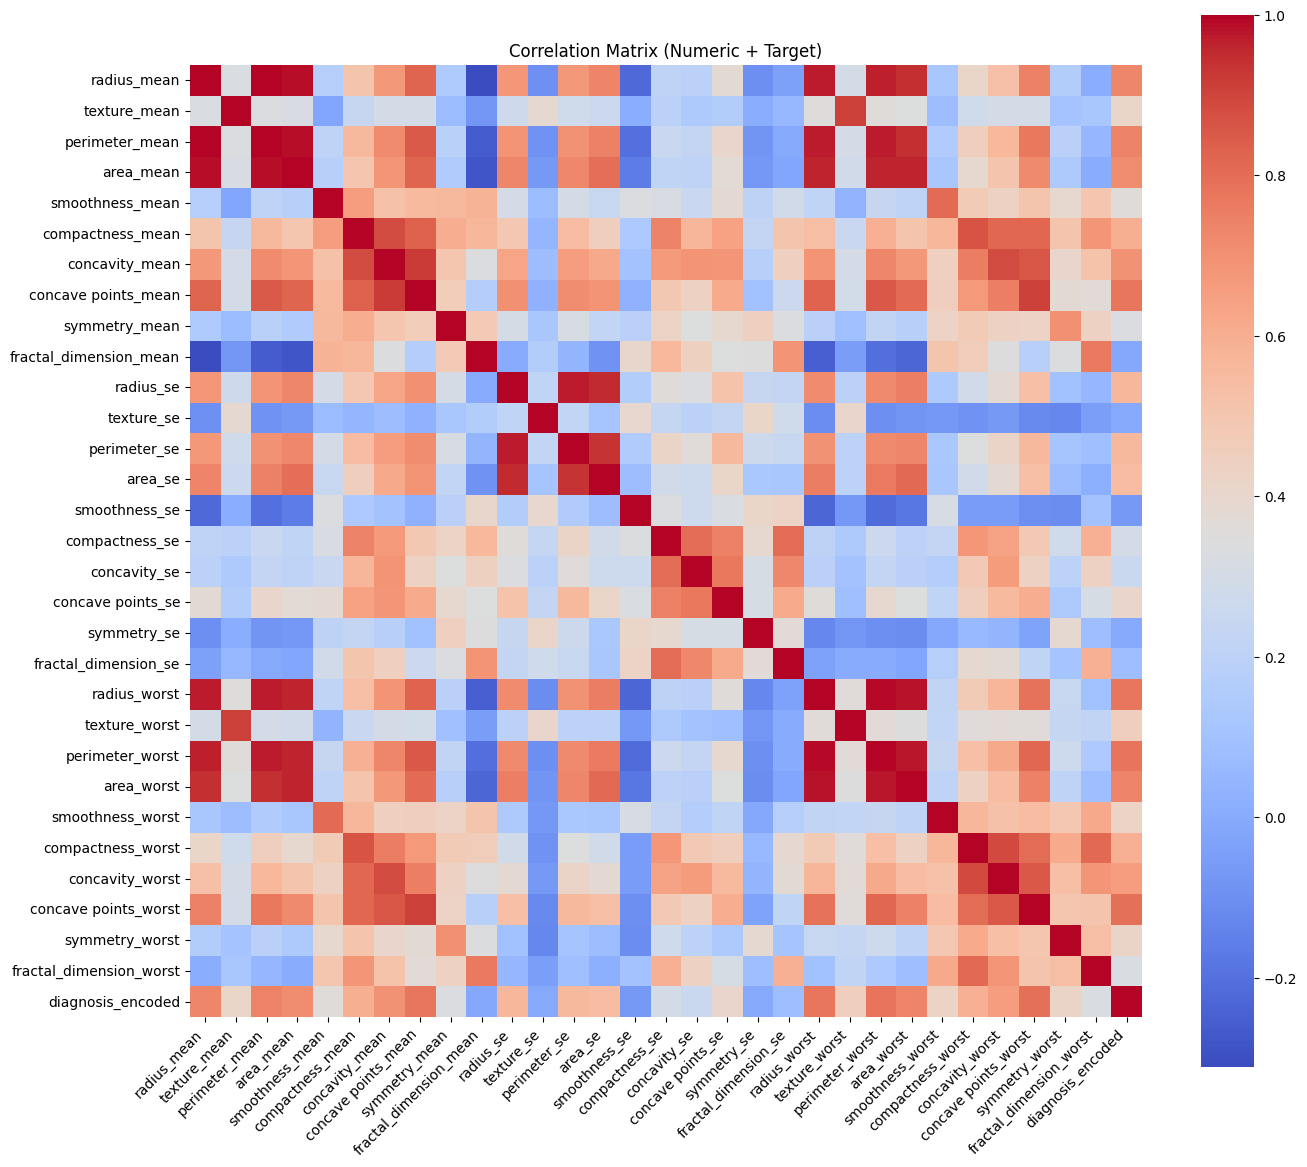

In [67]:
# Convert diagnosis to numeric (M=1, B=0)
data['diagnosis_encoded'] = data['diagnosis'].map({'M': 1, 'B': 0})

# Select numeric columns + encoded target
numeric_with_target = data[numerical_cols + ['diagnosis_encoded']]
corr = numeric_with_target.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=False, cmap="coolwarm", square=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Matrix (Numeric + Target)")
plt.tight_layout()
plt.show()

The above correlation matrix displays very correlated groups of features, and some others that are worth including in our final model to aid in prediction.
Particularily:
- Area, permiter and radius features are all very correlated with each other. This is to be expected because they all explain the shape of the tumor.
- Compactness, concavity and concave points features are moderately correlated with each other.

Additionally, it is extremely important to point out that <u>some features exist in a `_worst`, `_se`, `_mean`, or other forms. These are all **extremely** correlated with their counterparts, so we can safely filter out some that would mean additional redundancy in the model's predictors.</u>

Finally, let's take a closer look at the correlation between the predictors and the target variable.

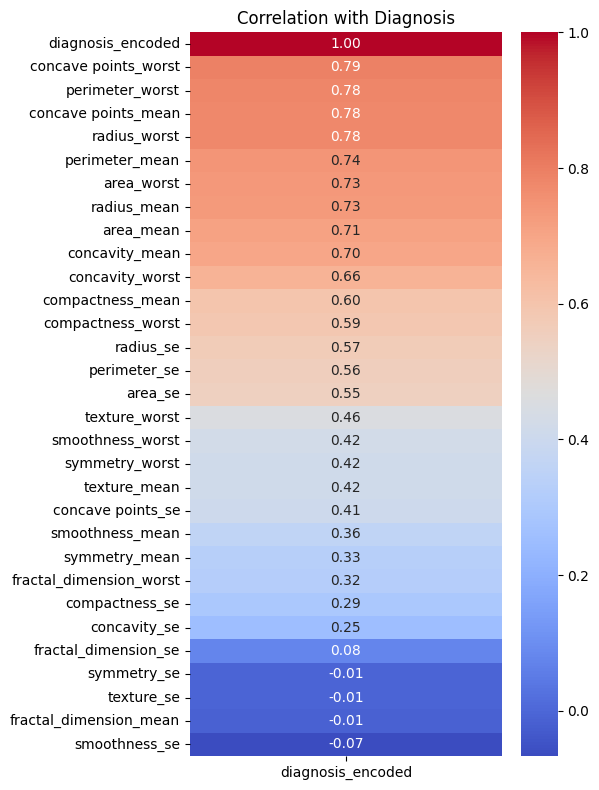

In [68]:
target_corr = corr['diagnosis_encoded'].sort_values(ascending=False)

plt.figure(figsize=(6, 8))
sns.heatmap(
    target_corr.to_frame(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Correlation with Diagnosis")
plt.tight_layout()
plt.show()

From this extrapolated graph, we can assume that there are, at the very least, 5 to 10 features that could be safely excluded from the final model. This is because they are seemingly useless in explaining the final result, at least linearly.

The top 10 correlated features with the target are the following:

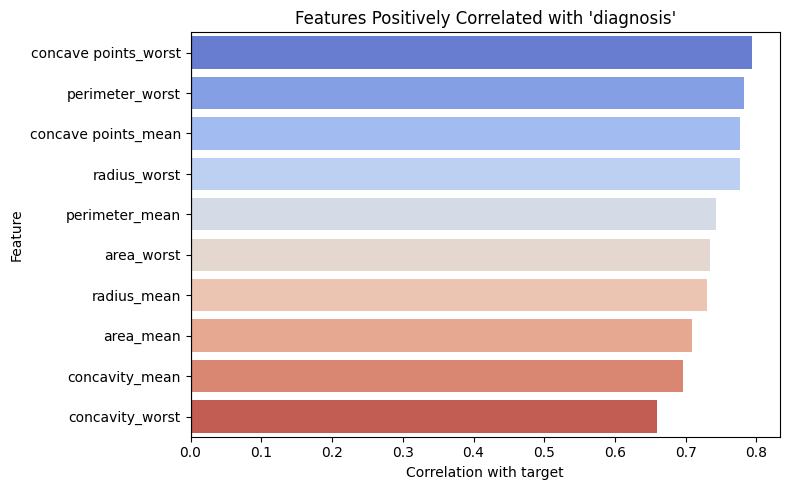

In [69]:
top_features = target_corr.drop('diagnosis_encoded').head(10)

plt.figure(figsize=(8, 5))

sns.barplot(
    x=top_features.values,
    y=top_features.index,
    hue=top_features.index,
    palette="coolwarm",
    legend=False
)
plt.axvline(0, color='black', linewidth=0.8)
plt.title("Features Positively Correlated with 'diagnosis'")
plt.xlabel("Correlation with target")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

 # Key Findings


Regarding the target:
- The class distribution is **imbalanced**. Benign cases outnumber malignant ones.
- This means **accuracy alone is not a reliable evaluation metric** for future models. Metrics like F1-score, AUC-ROC, or precision/recall should be used instead.

Conclusive from the correlation matrices:
- **Area, perimeter, and radius** features are highly correlated with each other.
- **Compactness, concavity, and concave points** are moderately correlated with each other.
- Features come in three variants (`_mean`, `_se`, `_worst`). These variants are **strongly correlated with each other**, creating significant redundancy across the feature space.

How this affect predictions:
- Several features show **strong positive correlation** with the target, most notably: `concave points_worst`, `perimeter_worst`, `radius_worst`, and `area_worst`.
- An estimated **5-10 features can be safely excluded** from the model due to almost no correlation with the target. Likely the standard error (`_se`) variants and shape properties such as `fractal_dimension` and `symmetry`.

## Feature Selection

Based on the previous EDA, we can now decide which columns to retain for modeling. The decisions are guided by three findings:

1. **`_se` variants are all dropped**: they show consistently low correlation with the target and are redundant with their `_mean` and `_worst` counterparts.
2. **`radius`, `perimeter`, `area` are highly correlated with each other**: we keep only the `_worst` form of each, as the `_worst` group was the most indicative. This is largely because `_worst` variants display an abnormal behavior in malignant cancer types, whereas `_se` and `_mean` variants are brought down by more normal cells, despite the malignancy of the whole tumor.
3. **`fractal_dimension` and `symmetry` are dropped**: they show almost no correlation with `diagnosis` and add no value to the prediction.

The kept columns are:

| Feature | Rationale |
|---|---|
| `radius_worst` | It's the best indicator for tumor size in the group |
| `texture_worst` | Moderate correlation |
| `perimeter_worst` | Strong correlation |
| `area_worst` | Strong correlation |
| `smoothness_worst` | Keep at least one `smoothness` for representation |
| `compactness_worst` | Strong correlation |
| `compactness_mean` | Moderate correlation, complements worst |
| `concavity_worst` | Strong correlation |
| `concavity_mean` | Strong correlation, complements worst, low redundancy |
| `concave points_worst` | Strong correlation |

In [70]:
columns_to_keep = [
    'diagnosis',
    'radius_worst', 'perimeter_worst', 'area_worst',
    'texture_worst',
    'smoothness_worst',
    'compactness_mean', 'compactness_worst',
    'concavity_mean', 'concavity_worst',
    'concave points_worst',
]

data_model = data[columns_to_keep].copy()
print(f"Features retained: {len(columns_to_keep) - 1}")  # exclude target - 1
print(f"Features dropped:  {len(numerical_cols) - (len(columns_to_keep) - 1)}")
data_model.head()

Features retained: 10
Features dropped:  20


,diagnosis,radius_worst,perimeter_worst,area_worst,texture_worst,smoothness_worst,compactness_mean,compactness_worst,concavity_mean,concavity_worst,concave points_worst
0,M,25.38,184.60,2019.0,17.33,0.1622,0.27760,0.6656,0.3001,0.7119,0.2654
1,M,24.99,158.80,1956.0,23.41,0.1238,0.07864,0.1866,0.0869,0.2416,0.1860
2,M,23.57,152.50,1709.0,25.53,0.1444,0.15990,0.4245,0.1974,0.4504,0.2430
3,M,14.91,98.87,567.7,26.50,0.2098,0.28390,0.8663,0.2414,0.6869,0.2575
4,M,22.54,152.20,1575.0,16.67,0.1374,0.13280,0.2050,0.1980,0.4000,0.1625


# Preprocessing Pipelines

# Preprocessing Pipelines

Given the previous analysis of the dataset, a preprocessing pipeline can be built to feed the inputs into the model created in a later cell. We will use a `ColumnTransformer` to independently apply different transformations to each feature group, with each transformation defined as a sub-pipeline using `make_pipeline`.

### Transformation Justifications

**Target — `LabelEncoder` on `diagnosis`:**
`diagnosis` is a binary target variable (`M`/`B`), so it only needs to be mapped to two integers (0 and 1). `OneHotEncoding` is designed for multi-class *input* features and would create two redundant columns, which is not the expected format for a binary classifier.

**`PowerTransformer(method='yeo-johnson')` on skewed features:**
Features like `area_worst` (mean=880, median=686), `concavity_worst`, and `compactness_worst` are right-skewed — their means exceed their medians and they have long upper tails. Yeo-Johnson handles zero values (unlike a log transform) and brings distributions closer to Gaussian, which improves the performance of linear models and SVMs.

**`StandardScaler` on all features:**
The retained features span vastly different scales, from `smoothness_worst` (0.07–0.22) to `area_worst` (185–4254). Standardizing to zero mean and unit variance prevents high-magnitude features from dominating distance-based and gradient-based computations in the model.

In [71]:
le = LabelEncoder()
y = le.fit_transform(data_model["diagnosis"])  # B=0, M=1
X = data_model.drop(columns=["diagnosis"])

preprocessor = ColumnTransformer(
    transformers=[
        (
            "skewed",
            make_pipeline(PowerTransformer(method="yeo-johnson"), StandardScaler()),
            [
                "area_worst",
                "perimeter_worst",
                "radius_worst",
                "concavity_mean",
                "concavity_worst",
                "compactness_mean",
                "compactness_worst",
                "concave points_worst",
            ],
        ),
        ("normal", StandardScaler(), ["texture_worst", "smoothness_worst"]),
    ]
)


Split the dataset into training and test sets, preserving the original class distribution in both sets by using the `stratify` parameter.

In [72]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

The malignancy distribution is preserved in both the training and test set due to the use of the `stratify` paramater during the split.

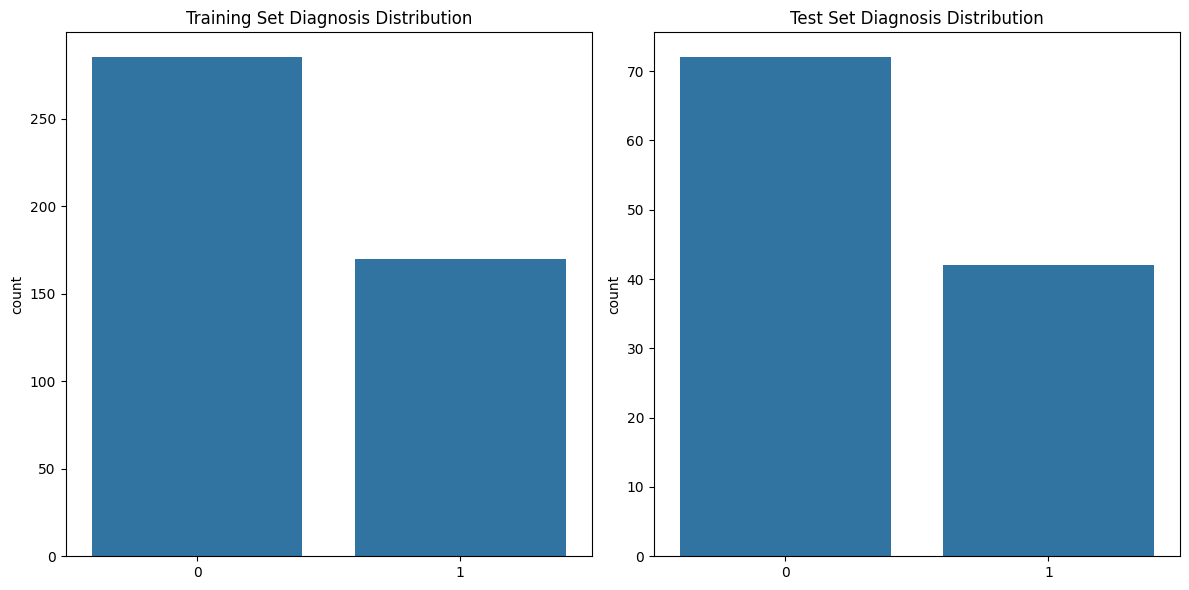

In [73]:
fig, axs = plt.subplots(1 , 2, figsize=(12, 6))
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title('Training Set Diagnosis Distribution')
sns.countplot(x=y_test, ax=axs[1])
axs[1].set_title('Test Set Diagnosis Distribution')
plt.tight_layout()

In [74]:
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

### Defining objective metrics

In [ ]:
random_forest_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

random_forest_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=random_forest_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='recall'
)

random_forest_grid_search.fit(x_train_processed, y_train)

In [75]:
# xgboost

In [76]:
# random_forest

In [77]:
# lr_param_grid = {
    